In [1]:
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
DATA_ROOT = "data/cart/"

# Regression Tree

## basec function

In [3]:
def loadDataSet(filename):
    dataList = []
    fr = open(filename)
    for line in fr.readlines():
        lineList = line.split('\t')
        lineList = map(np.float, lineList)
        dataList.append(lineList)
    return np.array(dataList)

def binSplitDataSet(dataArr, feature, value):
    branch1 = dataArr[dataArr[:, feature] > value]
    branch2 = dataArr[dataArr[:, feature] <= value]
    return branch1, branch2

In [4]:
testArr = np.eye(4)
branch1, branch2 = binSplitDataSet(testArr, 1, 0.5)
print("branch1", branch1)
print("branch2", branch2)

('branch1', array([[ 0.,  1.,  0.,  0.]]))
('branch2', array([[ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]]))


## choose best split

In [5]:
def regLeaf(dataArr):
    return dataArr[:,-1].mean() # the last colum is labels

def regErr(dataArr):
    targetValue = dataArr[:,-1]
    #return np.sum((targetValue - np.mean(targetValue))**2)
    # or
    return np.var(targetValue) * len(targetValue)

In [6]:
def chooseBestSplit(dataArr, leafTypeFunc=regLeaf, errTpyeFunc=regErr, ops=(1,4)):
    # node: the last column is target value
    
    toleranceE = ops[0]  # the mininum error threshold to stop split
    toleranceN = ops[1]  # the minimum number of instance to stop split
    if len(set(dataArr[:,-1])) == 1:
        # all of target value are equal, stop split
        return None, leafTypeFunc(dataArr)
    
    # iterate to find the best split position
    m, n = dataArr.shape
    errOrigin = errTpyeFunc(dataArr)
    bestErr = np.inf
    bestInd = 0
    bestSplitVal = 0
    for featInd in range(n-1):
        for splitVal in set(dataArr[:,featInd]):
            branch1, branch2 = binSplitDataSet(dataArr, featInd, splitVal)
            if (len(branch1) < toleranceN) or (len(branch2) < toleranceN):
                continue
            tempErr = errTpyeFunc(branch1) + errTpyeFunc(branch2)
            if tempErr < bestErr:
                bestErr = tempErr
                bestInd = featInd
                bestSplitVal = splitVal
                
    if (errOrigin - bestErr) < toleranceE:
        # the decreasing of error not very manifist significant, so stop split
        return None, leafTypeFunc(dataArr)
    
    # split data set by best split position
    branch1, branch2 = binSplitDataSet(dataArr, bestInd, bestSplitVal)
    if (len(branch1) < toleranceN or len(branch2) < toleranceN):
        return None, leafTypeFunc(dataArr)
    
    return bestInd, bestSplitVal

## Create Tree

In [7]:
def createTree(dataArr, leafTypeFunc=regLeaf, errTpyeFunc=regErr, ops=(1,4)):
    featInd, splitVal = chooseBestSplit(dataArr, leafTypeFunc, errTpyeFunc, ops)
    if featInd == None : 
        return splitVal
    
    retTree = {}
    retTree['splitInd'] = featInd
    retTree['splitVal'] = splitVal
    
    branch1, branch2 = binSplitDataSet(dataArr, featInd, splitVal)
    retTree['left'] = createTree(branch1, leafTypeFunc, errTpyeFunc, ops)
    retTree['right'] = createTree(branch2, leafTypeFunc, errTpyeFunc, ops)
    
    return retTree

## Test

### Case - 1

(200, 2)
[[ 0.036098  0.155096]
 [ 0.993349  1.077553]
 [ 0.530897  0.893462]]


{'left': 1.0180967672413792,
 'right': -0.044650285714285719,
 'splitInd': 0,
 'splitVal': 0.48813000000000001}

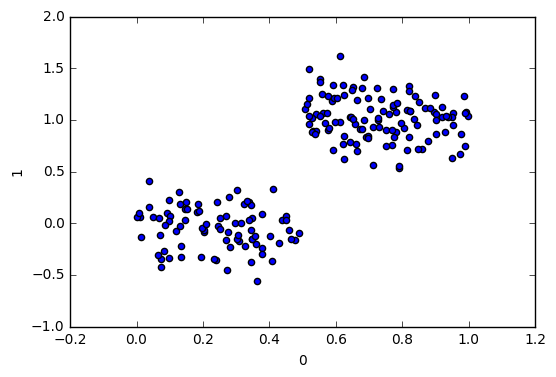

In [20]:
dataArr = loadDataSet(DATA_ROOT + 'ex00.txt')
print(dataArr.shape)
print(dataArr[:3,:])
plt.scatter(dataArr[:,0], dataArr[:,1])
plt.xlabel('0')
plt.ylabel('1')
createTree(dataArr) # 2 leaf node

### Case-2

(200, 2)
[[ 0.409175  1.88318 ]
 [ 0.182603  0.063908]
 [ 0.663687  3.042257]]


{'left': {'left': {'left': 3.9871631999999999,
   'right': 2.9836209534883724,
   'splitInd': 0,
   'splitVal': 0.79758300000000004},
  'right': 1.980035071428571,
  'splitInd': 0,
  'splitVal': 0.58200200000000002},
 'right': {'left': 1.0289583666666666,
  'right': -0.023838155555555553,
  'splitInd': 0,
  'splitVal': 0.19783400000000001},
 'splitInd': 0,
 'splitVal': 0.39434999999999998}

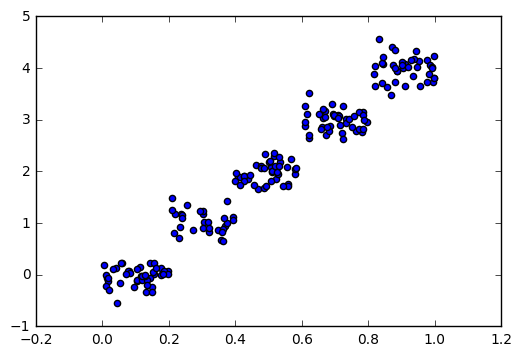

In [19]:
dataArr = loadDataSet(DATA_ROOT + 'ex0.txt')
dataArr = dataArr[:,1::]
print(dataArr.shape)
print(dataArr[:3,:])
plt.scatter(dataArr[:,0], dataArr[:,1])
createTree(dataArr) # 5 leaf node

## Tree pruning

### pre-pruning

### post-pruning

In [8]:
def isTree(obj):
    return type(obj).__name__ == 'dict'

def getMean(tree):
    if isTree(tree['left']) :
        tree['left'] = getMean(tree['left'])
    if isTree(tree['right']):
        tree['right'] = getMean(tree['right'])
        
    return (tree['left'] + tree['right'])/2.0


def prune(tree, testDataArr):
    if len(testDataArr) == 0: # #if we have no test data collapse the tree
        return getMean(tree) 
    
    if (not isTree(tree['left'])) and (not isTree(tree['right'])):
        # leaf, try to merge
        lDataArr, rDataArr = binSplitDataSet(testDataArr, tree['splitInd'], tree['splitVal'])
        errLeft = np.sum(np.power(lDataArr[:,-1] - tree['left'], 2))
        errRight = np.sum(np.power(rDataArr[:,-1] - tree['right'], 2))
        errNoMerge = errLeft + errRight
        treeMean = (tree['left'] + tree['right'])/2.0
        errMerge = np.sum(np.power(testDataArr - treeMean, 2))
        #print(errNoMerge, errMerge)
        if errMerge < errNoMerge:
            print ("merging.....")
            return treeMean
        else:
            return tree
    else: 
        lDataArr, rDataArr = binSplitDataSet(testDataArr, tree['splitInd'], tree['splitVal'])
        if ( isTree(tree['left']) ):
            tree['left'] = prune(tree['left'], lDataArr)
        if ( isTree(tree['right']) ):
            tree['right'] = prune(tree['right'], rDataArr)
        return tree

In [39]:
trainDataArr = loadDataSet(DATA_ROOT + 'ex2.txt')
print(trainDataArr.shape)
testDataArr = loadDataSet(DATA_ROOT + 'ex2test.txt')
print(testDataArr.shape)
treeDic = createTree(trainDataArr, ops=(0,1))
treePruned = prune(treeDic, testDataArr)
print(treePruned)

(200, 2)
(200, 2)
merging.....
merging.....
merging.....
merging.....
merging.....
merging.....
merging.....
merging.....
{'splitInd': 0, 'right': {'splitInd': 0, 'right': {'splitInd': 0, 'right': {'splitInd': 0, 'right': {'splitInd': 0, 'right': {'splitInd': 0, 'right': {'splitInd': 0, 'right': {'splitInd': 0, 'right': {'splitInd': 0, 'right': {'splitInd': 0, 'right': {'splitInd': 0, 'right': {'splitInd': 0, 'right': 0.64550600000000014, 'splitVal': 0.028545999999999998, 'left': {'splitInd': 0, 'right': 11.220098999999999, 'splitVal': 0.039913999999999998, 'left': 3.8553929999999998}}, 'splitVal': 0.044736999999999999, 'left': {'splitInd': 0, 'right': -13.731698, 'splitVal': 0.053763999999999999, 'left': {'splitInd': 0, 'right': -3.131497, 'splitVal': 0.055862000000000002, 'left': 6.6955669999999996}}}, 'splitVal': 0.061219000000000003, 'left': -15.160836}, 'splitVal': 0.068373000000000003, 'left': 15.824970500000001}, 'splitVal': 0.080060999999999993, 'left': -24.132225999999999}, 's

# Model Tree

In [9]:
def linearSolve(dataArr):
    m, n = dataArr.shape
    X = np.ones((m,n))
    y = np.ones(m)
    X[:,1:n] = dataArr[:,:-1]
    y = dataArr[:,-1]
    X = np.mat(X)
    y = np.mat(y).T
    
    xTx = X.T * X
    if np.linalg.det(xTx) == 0:
        raise NameError("This matrix is singular, cannot do inverse, \n\ try increasing the second value of ops")
    
    wHat = xTx.I * (X.T * y)
    return wHat.A, X.A, y.A

def modelLeaf(dataArr):
    wHat, _, _ = linearSolve(dataArr)
    return wHat

def modelErr(dataArr):
    wHat, X, y, = linearSolve(dataArr)
    yHat = np.mat(X)*np.mat(wHat)
    return np.sum(np.power(y-yHat.A, 2))

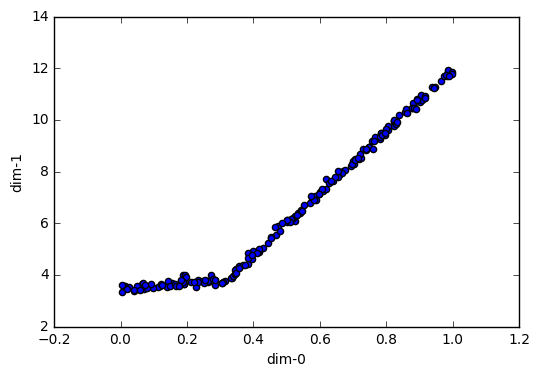

In [51]:
dataArr = loadDataSet(DATA_ROOT + 'exp2.txt')
plt.scatter(dataArr[:,0], dataArr[:,1])
plt.xlabel('dim-0')
plt.ylabel('dim-1')

In [83]:
modelTree = createTree(dataArr, modelLeaf, modelErr, ops=(1,10))
modelTree

{'left': array([[  1.69855694e-03],
        [  1.19647739e+01]]), 'right': array([[ 3.46877936],
        [ 1.18521743]]), 'splitInd': 0, 'splitVal': 0.28547699999999998}

# Compare CART with standar linear regression

In [72]:
def regTreeEval(model, inData):
    return model

def modelTreeEval(model, inData):
    model = np.mat(model)
    
    n = len(model)
    X = np.mat(np.ones([1, n]))
#     print(X.shape)
#     print(inData.shape)
#     print(inData[:-1])
    X[:,1::] = inData[:-1]
    return np.float(X*model)

def treeForecast(tree, inData, modelEvalFunc = regTreeEval):
    if not isTree(tree): # leaf
        return modelEvalFunc(tree, inData)
    
    if (inData[tree['splitInd']] > tree['splitVal']): # left tree
        if isTree(tree['left']):
            return treeForecast(tree['left'], inData, modelEvalFunc)
        else:
            return modelEvalFunc(tree['left'], inData)
    else:
        # right tree
        if isTree(tree['right']):
            return treeForecast(tree['right'], inData, modelEvalFunc)
        else:
            return modelEvalFunc(tree['right'], inData)

def createForecast(tree, testDataArr, modelEvalFunc = regTreeEval):
    m = len(testDataArr)
    yHat = np.zeros(m)
    for i in range(m):
        yHat[i] = treeForecast(tree, testDataArr[i], modelEvalFunc)
    return yHat

In [74]:
## regression tree
trainDataArr = loadDataSet(DATA_ROOT + 'bikeSpeedVsIq_train.txt')
testDataArr = loadDataSet(DATA_ROOT + 'bikeSpeedVsIq_test.txt')
tree = createTree(trainDataArr, regLeaf, regErr, (1,20))
print(tree)

yHat = createForecast(tree, testDataArr, regTreeEval)
print("\ncorrelation coeficent : ")
print(np.corrcoef(yHat, testDataArr[:,-1]))

{'splitInd': 0, 'right': {'splitInd': 0, 'right': {'splitInd': 0, 'right': 50.946836650000002, 'splitVal': 5.0, 'left': 69.02117757692308}, 'splitVal': 7.0, 'left': 94.706657812499998}, 'splitVal': 10.0, 'left': {'splitInd': 0, 'right': {'splitInd': 0, 'right': 122.90893026923078, 'splitVal': 14.0, 'left': 141.06067981481482}, 'splitVal': 17.0, 'left': {'splitInd': 0, 'right': 157.04840788461539, 'splitVal': 20.0, 'left': 168.34161286956524}}}

correlation coeficent : 
[[ 1.          0.96408523]
 [ 0.96408523  1.        ]]


In [75]:
## model tree
trainDataArr = loadDataSet(DATA_ROOT + 'bikeSpeedVsIq_train.txt')
print(trainDataArr.shape)
testDataArr = loadDataSet(DATA_ROOT + 'bikeSpeedVsIq_test.txt')
print(testDataArr.shape)
tree = createTree(trainDataArr, modelLeaf, modelErr, (1,20))
print(tree)

yHat = createForecast(tree, testDataArr, modelTreeEval)
print("\ncorrelation coeficent : ")
print(np.corrcoef(yHat, testDataArr[:,-1]))

(200, 2)
(200, 2)
{'splitInd': 0, 'right': array([[ 68.87014372],
       [-11.78556471]]), 'splitVal': 4.0, 'left': {'splitInd': 0, 'right': {'splitInd': 0, 'right': {'splitInd': 0, 'right': array([[-17.21714265],
       [ 13.72153115]]), 'splitVal': 6.0, 'left': array([[-11.84548851],
       [ 12.12382261]])}, 'splitVal': 9.0, 'left': array([[ -2.87684083],
       [ 10.20804482]])}, 'splitVal': 12.0, 'left': {'splitInd': 0, 'right': array([[ 43.41251481],
       [  6.37966738]]), 'splitVal': 16.0, 'left': {'splitInd': 0, 'right': array([[ 37.54851927],
       [  6.23298637]]), 'splitVal': 20.0, 'left': array([[ 47.58621512],
       [  5.51066299]])}}}}

correlation coeficent : 
[[ 1.          0.97604122]
 [ 0.97604122  1.        ]]


In [112]:
## standar linear regression
trainDataArr = loadDataSet(DATA_ROOT + 'bikeSpeedVsIq_train.txt')
print(trainDataArr.shape)
testDataArr = loadDataSet(DATA_ROOT + 'bikeSpeedVsIq_test.txt')
print(testDataArr.shape)
print("\n")

wHat, X, y = linearSolve(trainDataArr)
#print(wHat)
yHat = []
#wHat = np.mat(wHat)
#print(wHat.shape)
n = len(wHat)
for i in range(len(testDataArr)):
    XTest = np.ones([1, n])
    XTest[0,1::] = testDataArr[i,:-1]
    #print(XTest)
    XTest = np.mat(XTest)
    
    temp = np.float(XTest*wHat)
    yHat.append( temp )

print(np.corrcoef(yHat, testDataArr[:,-1]))

(200, 2)
(200, 2)


[[ 1.          0.94346842]
 [ 0.94346842  1.        ]]
